# Notebook to read in raw WRF NetCDF history files

Goal is to read in Antarctic Mesoscale Prediction System (AMPS) outputs stored in LDEO's Google Bucket (gs://ldeo-glaciology/) and eventually convert to zarr

In [1]:
import xarray as xr
import numpy as np
from glob import glob

import gcsfs
from tqdm import tqdm
import fsspec

xr.set_options(display_style="html");

In [2]:
xr.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:59:12) 
[Clang 11.0.1 ]
python-bits: 64
OS: Darwin
OS-release: 19.6.0
machine: x86_64
processor: i386
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8
libhdf5: 1.10.6
libnetcdf: 4.7.4

xarray: 0.17.0
pandas: 1.2.3
numpy: 1.20.1
scipy: 1.6.0
netCDF4: 1.5.6
pydap: None
h5netcdf: 0.8.1
h5py: 3.1.0
Nio: None
zarr: 2.6.1
cftime: 1.4.1
nc_time_axis: None
PseudoNetCDF: None
rasterio: None
cfgrib: None
iris: None
bottleneck: 1.3.2
dask: 2021.03.0
distributed: 2021.03.0
matplotlib: 3.3.4
cartopy: 0.18.0
seaborn: None
numbagg: None
pint: None
setuptools: 49.6.0.post20210108
pip: 21.0.1
conda: None
pytest: None
IPython: 7.21.0
sphinx: None


### list the netcdf files

These are raw WRF output files.

In [3]:
NCs_urls = ['https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f003.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f006.nc#mode=bytes']


In [4]:
print(NCs_urls)

['https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f003.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f006.nc#mode=bytes']


### read in single wrfout file

In [5]:
ds = xr.open_dataset(NCs_urls[0], engine='netcdf4', chunks={'south_north': -1, 'west_east': -1})

In [6]:
ds.T2

<xarray.DataArray 'T2' (Time: 1, south_north: 786, west_east: 834)>
dask.array<open_dataset-fdfe4a2d384757d0f5283c64fd7aab11T2, shape=(1, 786, 834), dtype=float32, chunksize=(1, 786, 834), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

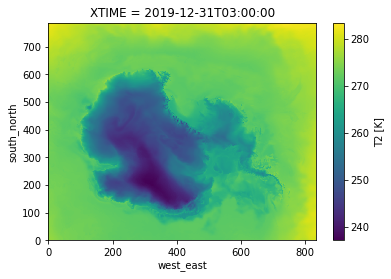

In [7]:
ds['T2'].plot()

### use `open_mfdataset` to open many files

note this works with post-processed, CF-compliant WRF output

In [10]:
ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True)#,
#                        concat_dim='Time', combine='by_coords')

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

### Looping Method using `contat`

In [73]:
import os

gcsdir = 'gs://ldeo-glaciology'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'
domain = 'domain_02'
filepattern = 'wrfout_d02_20191231*'
pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)

fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)
NCs = fs.glob(pattern)
print(f"Total of {len(NCs)} wrf files.\n")
print(NCs[0])
NCs_urls = ['https://storage.googleapis.com/' + x + '#mode=bytes' for x in NCs]
print(NCs_urls)

Total of 8 wrf files.

ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f003.nc
['https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f003.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f006.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f009.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f012.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f003.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f006.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f009.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f012.nc#mode=bytes']


In [17]:
with  fsspec.open(NCs_urls[0], mode='rb')  as openfile:  
    ds = xr.open_dataset(openfile, engine='h5netcdf', 
                         chunks={'south_north': 300, 'west_east': 300, 'Time': 1})  # , decode_coords=False
    
for i in tqdm(range(1, len(NCs_urls))):  
    with  fsspec.open(NCs_urls[i], mode='rb')  as openfile:  
        temp = xr.open_dataset(openfile, engine='h5netcdf', 
                               chunks={'south_north': 300, 'west_east': 300, 'Time': 1})  
    ds = xr.concat([ds,temp],'Time')
    
ds.T2

100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


<xarray.DataArray 'T2' (Time: 2, south_north: 786, west_east: 834)>
dask.array<concatenate, shape=(2, 786, 834), dtype=float32, chunksize=(1, 300, 300), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    [104]
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

In [56]:
# ds = xr.DataArray([])
# for i in tqdm(range(0, len(NCs_urls))):  
#     with  fsspec.open(NCs_urls[i], mode='rb')  as openfile:  
#         temp = xr.open_dataset(openfile, engine='h5netcdf', 
#                                chunks={'south_north': 300, 'west_east': 300, 'Time': -1})  
#     ds = xr.concat([ds,temp],'Time')
    
# ds.T2

  0%|          | 0/4 [00:00<?, ?it/s]


AttributeError: 'Dataset' object has no attribute 'name'

In [18]:
ds.XTIME.values

array(['2019-12-31T03:00:00.000000000', '2019-12-31T06:00:00.000000000'],
      dtype='datetime64[ns]')

In [19]:
ds.T2.mean().compute()

<xarray.DataArray 'T2' ()>
array(267.90945, dtype=float32)

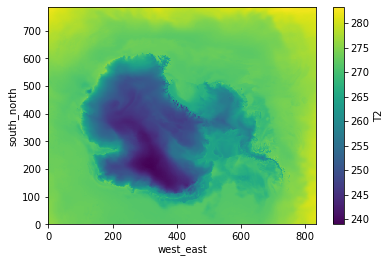

In [20]:
ds.T2.mean(dim='Time').plot()

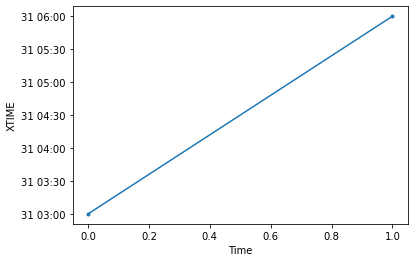

In [23]:
ds.XTIME.plot(marker='.')

In [22]:
print(ds.nbytes / 1e9)

5.030041102


### Test writing zarr to gcs

In [38]:
outfile = fsspec.get_mapper('gs://ldeo-glaciology/AMPS/WRF_test/wrfout_raw_test.zarr', mode='ab',
                            token='secrets/ldeo-glaciology-bc97b12df06b.json')

In [39]:
ds.to_zarr(outfile, mode='w');

TimeoutError: 

In [ ]:
type(outfile)

### test reading that zarr file

In [ ]:
gcsmap = gcsfs.mapping.GCSMap('gs://ldeo-glaciology/AMPS/WRF_test/wrfout_raw_test.zarr', gcs=fs, check=True, create=False)

AMPS_gcs = xr.open_zarr(outfile)

In [ ]:
AMPS_gcs.T2.isel(south_north = 200, west_east = 300).plot(x='Time')